# Face Mask Detection

In [1]:
import pandas as pd
import numpy as np
import cv2
import time
import torch
import os
import shutil
import glob
from tqdm import tqdm
import xml.etree.ElementTree as ET

import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from torchvision.transforms import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection import FasterRCNN


from PIL import Image
from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib.patches as patches

c:\Users\alex_\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Знакомство с данными

In [3]:
def xml_to_csv(path = 'data/FaceMaskDetection/Annotations'):
    xml_list = []
    for xml_file in tqdm(glob.glob(path + '/*.xml')):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for obj in root.findall('object'):
            bbx = obj.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = obj.find('name').text

            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     int(root.find('size')[2].text),
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'channels', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [4]:
xml_df = xml_to_csv()
xml_df.to_csv('facemaskdetection.csv', index=None)

100%|██████████| 853/853 [00:01<00:00, 667.67it/s]


In [32]:
print(f'Общее количество объектов {xml_df.shape[0]}')
print(f'Количество изображений в датафрэйме {len(np.unique(xml_df["filename"]))}')

Общее количество объектов 4072
Количество изображений в датафрэйме 853


In [33]:
display(xml_df.groupby('class').size())

class
mask_weared_incorrect     123
with_mask                3232
without_mask              717
dtype: int64

In [6]:
le = preprocessing.LabelEncoder()
xml_df['class'] = le.fit_transform(xml_df['class'])

In [7]:
mapping = dict(zip(le.classes_, range(len(le.classes_))))
mapping

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}

In [8]:
mapping_names = {v: k for k, v in mapping.items()}
mapping_names

{0: 'mask_weared_incorrect', 1: 'with_mask', 2: 'without_mask'}

In [43]:
xml_df

filename  channels  width  height  class  xmin  ymin  xmax  \
0      maksssksksss0.png       512    366       3      2    79   105   109   
1      maksssksksss0.png       512    366       3      1   185   100   226   
2      maksssksksss0.png       512    366       3      2   325    90   360   
3      maksssksksss1.png       400    156       3      1   321    34   354   
4      maksssksksss1.png       400    156       3      1   224    38   261   
...                  ...       ...    ...     ...    ...   ...   ...   ...   
4067  maksssksksss98.png       400    267       3      1   263    62   287   
4068  maksssksksss98.png       400    267       3      1   344    80   377   
4069  maksssksksss99.png       400    267       3      0   181    54   273   
4070  maksssksksss99.png       400    267       3      1    99    87   176   
4071  maksssksksss99.png       400    267       3      1   289    99   355   

      ymax  
0      142  
1      144  
2      141  
3       69  
4       73  
...    ...  
4067    85  
4068   106  
4069   162  
4070   165  
4071   233  

[4072 rows x 9 columns]

## Конвертация .xml аннотаций в .txt

In [13]:
def convert_to_yolov5(df, unique_img_names):

    df_array = np.array(df)

    # Для каждого объкта
    for i in range(len(df)):
        print_buffer = []

        point =  df_array[i]
        img_name = point[0]

        # Для каждого уникального изображения
        for unique_img_name in unique_img_names:
           if img_name == unique_img_name:
              class_id = point[4]
      
              # Преобразуем координаты bbox 
              X = (point[5] + point[7]) / 2 
              Y = (point[6] + point[8]) / 2 
              Width    = (point[7] - point[5])
              Height   = (point[8] - point[6])
              
              # Нормализуем координаты
              image_c, image_w, image_h = point[1], point[2], point[3] 
              X /= image_w 
              Y /= image_h 
              Width    /= image_w 
              Height   /= image_h 
              
              # Запишем информацию о bbox в файл
              print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, X, Y, Width, Height))
              
        # Дадим имя файлам, которые хотим сохранить
        save_file_name = os.path.join("data/FaceMaskDetection/images", img_name.replace("png", "txt"))
        
        # Сохраним аннотации на диск
        print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [67]:
# Для начала выделим список уникальных имен изображений
unique_img_names = xml_df['filename'].unique()
print(len(unique_img_names))

853


In [68]:
# Получим аннотации в новом формате
convert_to_yolov5(xml_df, unique_img_names)

## Разделим данные на обучающую и валидационную выборку

In [69]:
# Путь к папке, куда будет распакован архив
data_dir = 'data/FaceMaskDetection'

# Путь к папкам для хранения тренировочных и валидационных данных
train_path = 'data/train'
val_path = 'data/val'

# Размер валидационной выборки (в процентах)
val_size = 0.2

# Получаем список всех файлов меток
labels = []
for xml_file in os.listdir(os.path.join(data_dir, 'annotations')):
    if xml_file.endswith('.xml'):
        tree = ET.parse(os.path.join(data_dir, 'annotations', xml_file))
        root = tree.getroot()
        labels.append((root.find('filename').text, xml_file))

# Определяем количество файлов в валидационной выборке
val_count = int(len(labels) * val_size)

# Создаем папки для хранения тренировочных и валидационных данных
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(os.path.join(train_path, 'images'), exist_ok=True)
os.makedirs(os.path.join(train_path, 'labels'), exist_ok=True)
os.makedirs(os.path.join(val_path, 'images'), exist_ok=True)
os.makedirs(os.path.join(val_path, 'labels'), exist_ok=True)

# Переносим файлы в соответствующие папки
for img_file, xml_file in labels:
    # Получаем путь к метке и изображению
    label_path = os.path.join(data_dir, 'annotations', xml_file)
    img_path = os.path.join(data_dir, 'images', img_file)

    # Определяем, в какую папку поместить файлы
    if val_count > 0:
        path = val_path
        val_count -= 1
    else:
        path = train_path

    # Копируем файлы
    shutil.copy(img_path, os.path.join(path, 'images', img_file))

    # Конвертируем метки в формат yolo
    tree = ET.parse(label_path)
    root = tree.getroot()
    objects = root.findall('object')
    with open(os.path.join(path, 'labels', img_file.replace('.png', '.txt')), 'w') as f:
        img_width = int(root.find('size/width').text)
        img_height = int(root.find('size/height').text)
        for obj in objects:
            class_name = obj.find('name').text
            class_id = mapping[class_name]
            xmin = int(float(obj.find('bndbox/xmin').text))
            ymin = int(float(obj.find('bndbox/ymin').text))
            xmax = int(float(obj.find('bndbox/xmax').text))
            ymax = int(float(obj.find('bndbox/ymax').text))
            width = xmax - xmin
            height = ymax - ymin
            center_x = (xmin + xmax) / 2 / img_width
            center_y = (ymin + ymax) / 2 / img_height
            # Нормализуем координаты bbox
            width /= img_width
            height /= img_height
            f.write(f'{class_id} {center_x} {center_y} {width} {height}\n')


## YoloV5

In [65]:
# Создаем файл конфигурации для обучения
config_path = 'yolov5_fmd.yaml'
with open(config_path, 'w') as f:
    # Записываем базовую конфигурацию yolov5
    with open('yolov5/models/yolov5s.yaml') as base_config:
        f.write(base_config.read())

    # Записываем пути к тренировочным и валидационным данным
    f.write(f'path: ../data\n')
    f.write(f'train: train/images\n')
    f.write(f'val: val/images\n')
    f.write(f'names: {mapping_names}\n')
    #f.write(f'names: {",".join(le.classes_)}\n')

    # Записываем количество классов
    #num_classes = len(mapping_names)-1
    #f.write(f'nc: {num_classes}\n')

In [ ]:
# Запускаем обучение предобученной модели на 100 эпох и батчем 32
os.system(f'python yolov5/train.py --img 640 --batch 32 --epochs 100 --data yolov5_fmd.yaml --weights yolov5s.pt --name yolov5_fmd')

"""
                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 1/3 [00:00<00:01,  1.06it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 3/3 [00:06<00:00,  2.15s/it]
                   all        170        769      0.944      0.831      0.891      0.601
 mask_weared_incorrect        170         22      0.996      0.727      0.816       0.54
             with_mask        170        552      0.934      0.926      0.958      0.687
          without_mask        170        195      0.901       0.84        0.9      0.575
"""

### Метрики на обучающей выборке

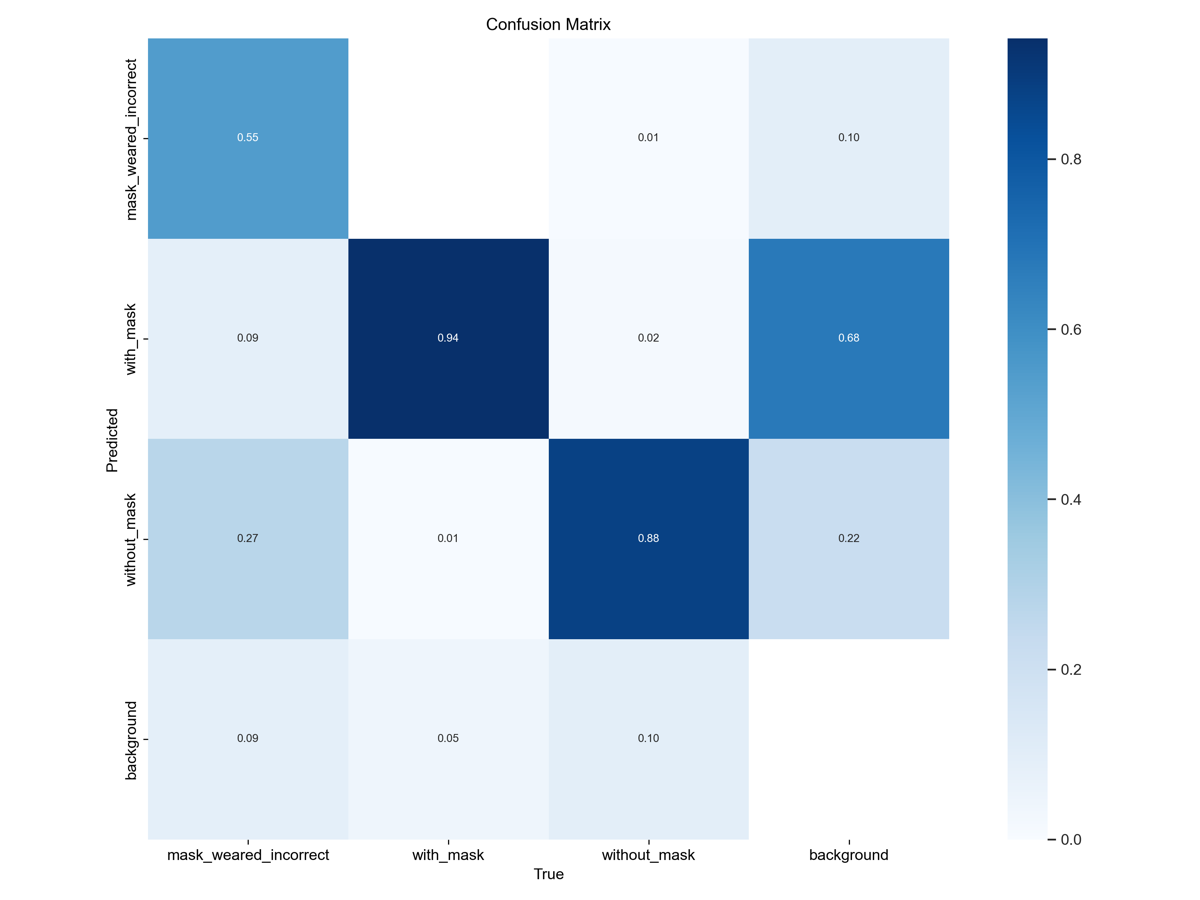

In [76]:
image = Image.open('yolov5/runs/train/yolov5_fmd2/confusion_matrix.png')
scale = 0.4
new_width = int(image.width * scale)
new_height = int(image.height * scale)

# Изменяем размер изображения
resized_image = image.resize((new_width, new_height))

# Отображаем измененное изображение
display(resized_image)

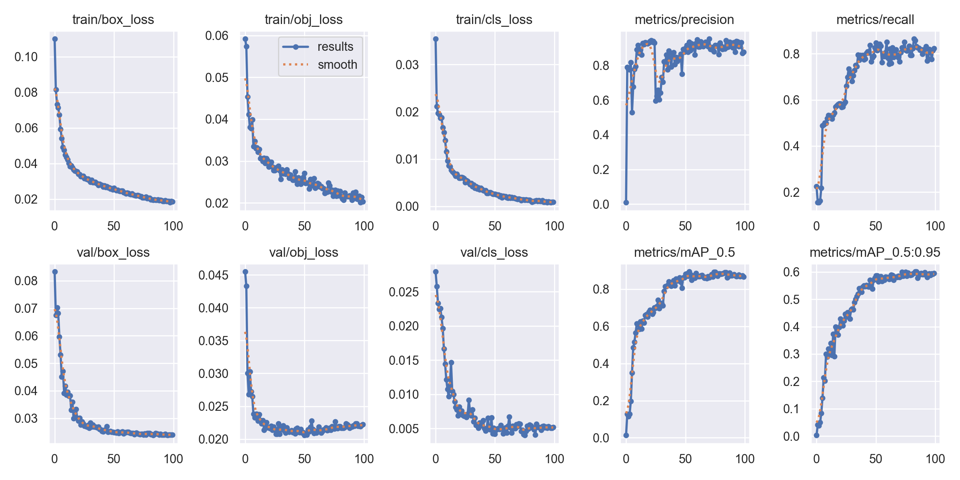

In [77]:
image = Image.open('yolov5/runs/train/yolov5_fmd2/results.png')
scale = 0.4
new_width = int(image.width * scale)
new_height = int(image.height * scale)

# Изменяем размер изображения
resized_image = image.resize((new_width, new_height))

# Отображаем измененное изображение
display(resized_image)

### Результат детекции после обучения

Исходные данные


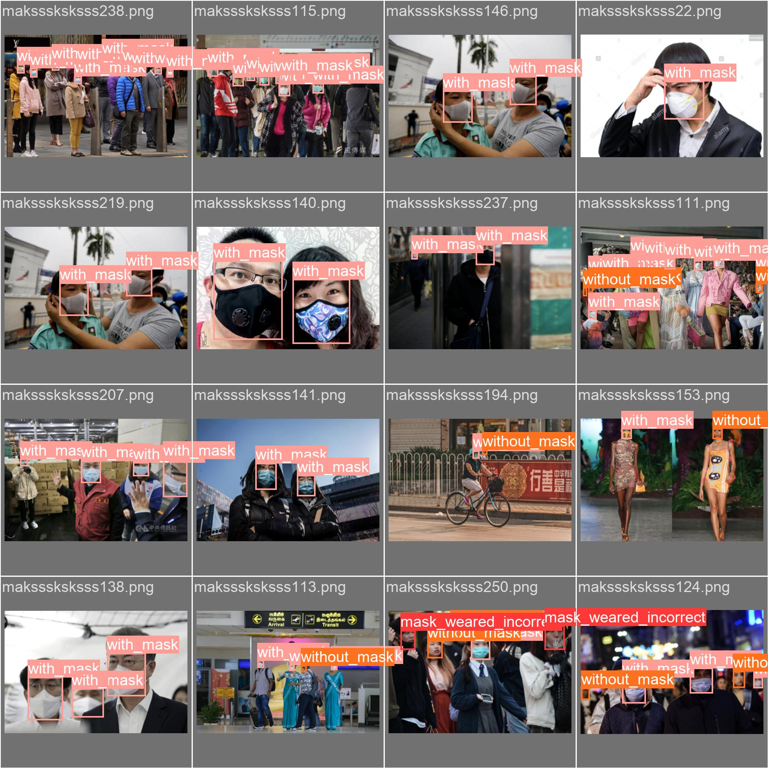

Предсказание модели


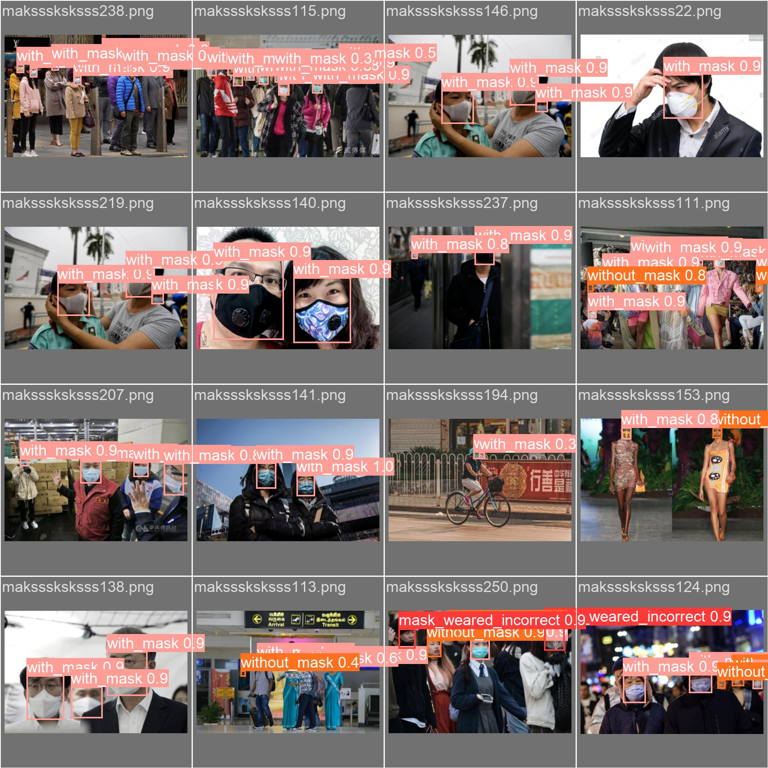

In [82]:
image = Image.open('yolov5/runs/train/yolov5_fmd2/val_batch1_labels.jpg')
scale = 0.4
new_width = int(image.width * scale)
new_height = int(image.height * scale)

# Изменяем размер изображения
resized_image = image.resize((new_width, new_height))

# Отображаем измененное изображение
print("Исходные данные")
display(resized_image)

image = Image.open('yolov5/runs/train/yolov5_fmd2/val_batch1_pred.jpg')
scale = 0.4
new_width = int(image.width * scale)
new_height = int(image.height * scale)

# Изменяем размер изображения
resized_image = image.resize((new_width, new_height))
print("Предсказание модели")
display(resized_image)

In [ ]:
os.system(f'yolov5/detect.py --source data/val/images --weights yolov5/runs/train/yolov5_fmd2/weights/best.pt --conf 0.25 --save-txt --save-conf --save-crop')

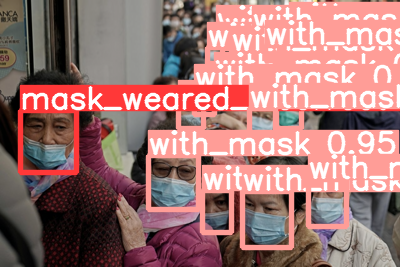

In [84]:
image = Image.open('yolov5/runs/detect/exp/maksssksksss11.png')

display(image)

In [ ]:
os.system(f'python yolov5/val.py --weights yolov5/runs/train/yolov5_fmd2/weights/best.pt --data yolov5_fmd.yaml --img 640')

"""
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 6/6 [00:03<00:00,  1.89it/s]
                   all        170        769      0.935       0.83      0.888      0.599
 mask_weared_incorrect        170         22      0.975      0.727      0.812      0.536
             with_mask        170        552      0.937      0.922      0.958      0.686
          without_mask        170        195      0.891      0.842      0.895      0.575
"""

### Метрики на валидационной выборке

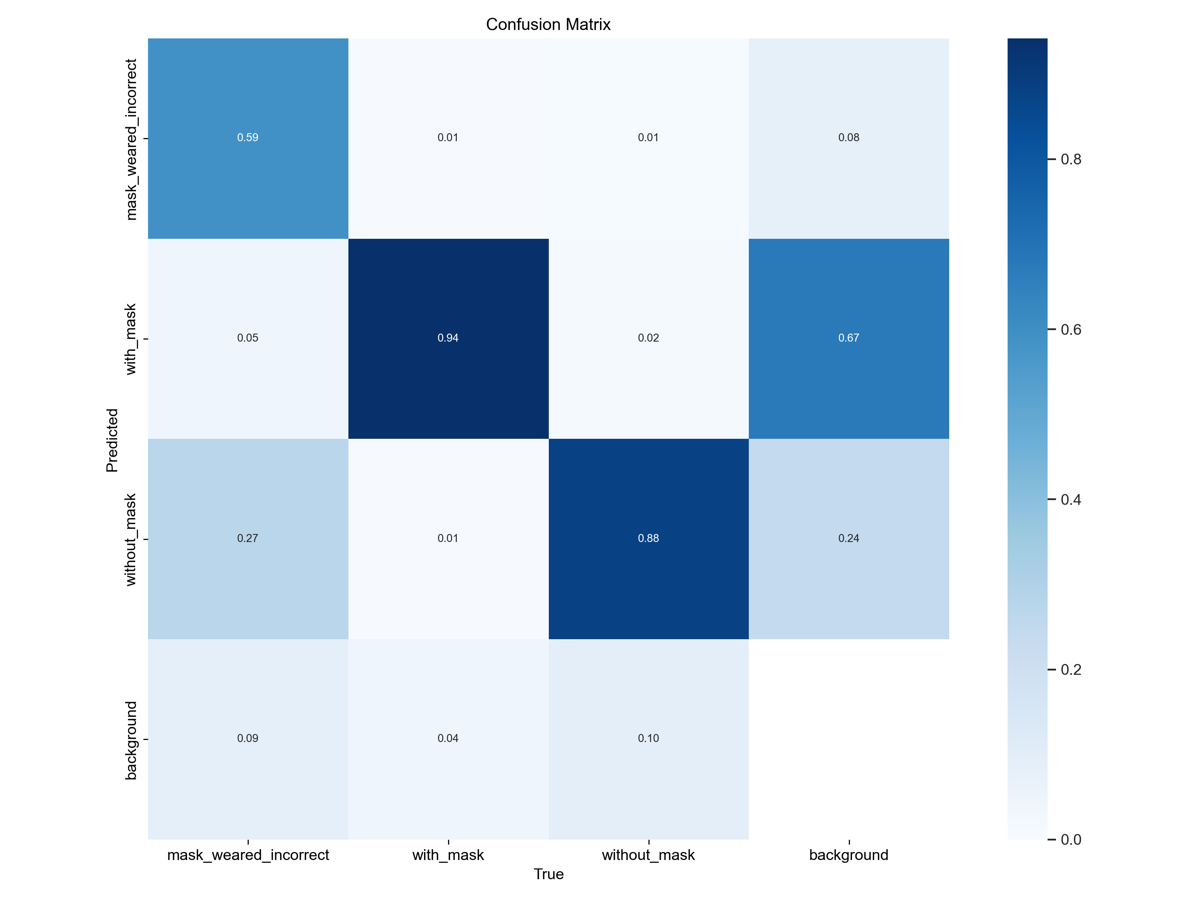

In [85]:
image = Image.open('yolov5/runs/val/exp2/confusion_matrix.png')
scale = 0.4
new_width = int(image.width * scale)
new_height = int(image.height * scale)

# Изменяем размер изображения
resized_image = image.resize((new_width, new_height))

# Отображаем измененное изображение
display(resized_image)

### Результат детекции после запуска detect.py и val.py

Исходные данные


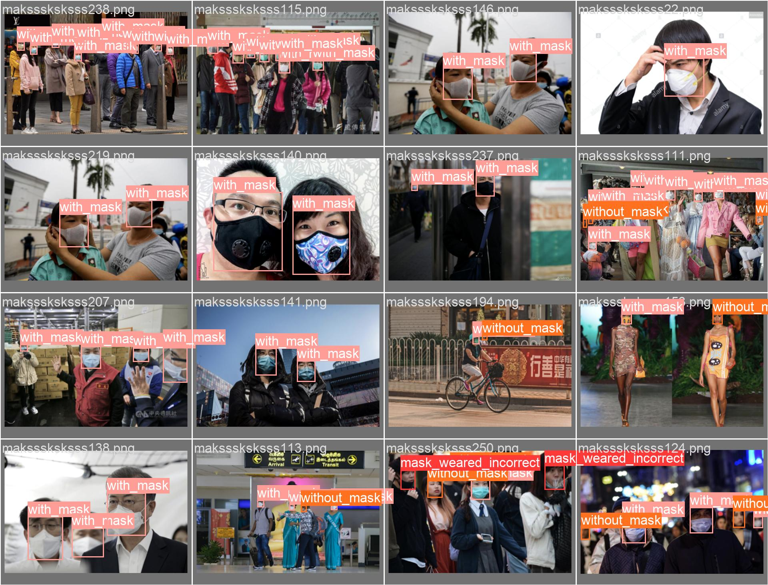

Предсказание модели


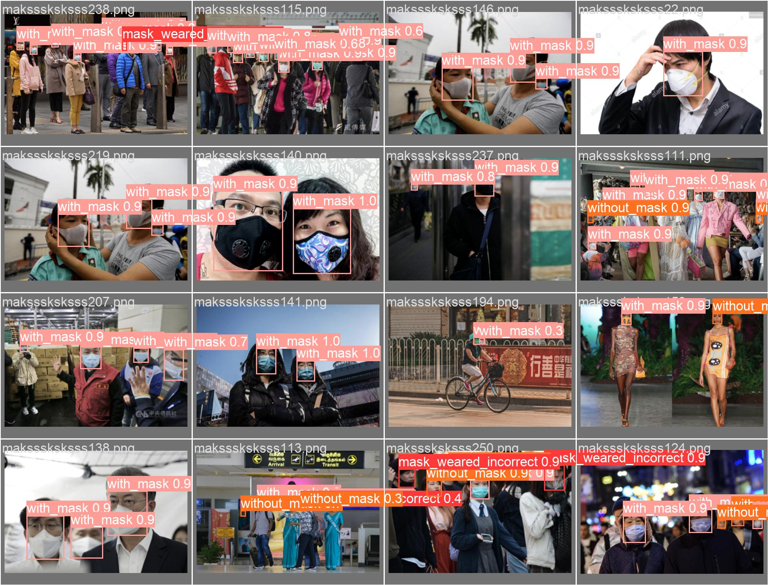

In [86]:
image = Image.open('yolov5/runs/val/exp2/val_batch2_labels.jpg')
scale = 0.4
new_width = int(image.width * scale)
new_height = int(image.height * scale)

# Изменяем размер изображения
resized_image = image.resize((new_width, new_height))

# Отображаем измененное изображение
print("Исходные данные")
display(resized_image)

image = Image.open('yolov5/runs/val/exp2/val_batch2_pred.jpg')
scale = 0.4
new_width = int(image.width * scale)
new_height = int(image.height * scale)

# Изменяем размер изображения
resized_image = image.resize((new_width, new_height))
print("Предсказание модели")
display(resized_image)

### Accuracy

In [88]:
folder_path = 'data/val/labels'

data_frames = []

for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path, sep='\s+', header=None, encoding='utf-8')
        df.insert(0, 'filename', filename)
        data_frames.append(df)

result_df = pd.concat(data_frames, ignore_index=True)
result_df = result_df.drop([1, 2, 3, 4], axis=1)
result_df = result_df.drop_duplicates()

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
C:\Users\alex_\AppData\Local\Temp\ipykernel_23840\459815037.py:8: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, sep='\s+', header=None, encoding='utf-8')


In [90]:
folder_path = 'yolov5/runs/detect/exp/labels'

data_frames = []

for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path, sep='\s+', header=None, encoding='utf-8')
        df.insert(0, 'filename', filename)
        data_frames.append(df)

detect_df = pd.concat(data_frames, ignore_index=True)
detect_df = detect_df.drop([1, 2, 3, 4, 5], axis=1)
detect_df = detect_df.drop_duplicates()

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
C:\Users\alex_\AppData\Local\Temp\ipykernel_23840\3036758616.py:8: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, sep='\s+', header=None, encoding='utf-8')


In [91]:
# Объединение двух DataFrame с общими элементами
accuracy_df = pd.merge(result_df, detect_df, how='inner')

# Вывод количества верно предсказанных меток
display(accuracy_df.shape[0])

220

In [92]:
# Разделим количество верно предсказанных меток на количество всех предсказаний
accuracy = accuracy_df.shape[0]/detect_df.shape[0]
display(accuracy)

0.9482758620689655

Модель довольно хорошо справилась с задачей детекции медицинских масок на лице. Думаю что для улучшения качества модели в детекции правильности ношения маски нужно больше входных данных. Также была замечена проблема в распознавании масок на лицах повернутых в профиль. В некоторых случаях модель распознала человека не размеченного в данных. В некоторых случаях человек на плакате был распознанан как человек без маски

## FasterRCNN

### Подготовим данные для обучения

In [3]:
# Путь к папке, куда будет распакован архив
data_dir = 'data/FaceMaskDetection'

# Путь к папкам для хранения тренировочных и валидационных данных
train_path = 'data/train'
val_path = 'data/val'

# Размер валидационной выборки (в процентах)
val_size = 0.2

# Получаем список всех файлов меток
labels = []
for xml_file in os.listdir(os.path.join(data_dir, 'annotations')):
    if xml_file.endswith('.xml'):
        tree = ET.parse(os.path.join(data_dir, 'annotations', xml_file))
        root = tree.getroot()
        labels.append((root.find('filename').text, xml_file))

# Определяем количество файлов в валидационной выборке
val_count = int(len(labels) * val_size)

# Создаем папки для хранения тренировочных и валидационных данных
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(os.path.join(train_path, 'images'), exist_ok=True)
os.makedirs(os.path.join(train_path, 'labels'), exist_ok=True)
os.makedirs(os.path.join(val_path, 'images'), exist_ok=True)
os.makedirs(os.path.join(val_path, 'labels'), exist_ok=True)

# Переносим файлы в соответствующие папки
for img_file, xml_file in labels:
    label_path = os.path.join(data_dir, 'annotations', xml_file)
    img_path = os.path.join(data_dir, 'images', img_file)

    if val_count > 0:
        path = val_path
        val_count -= 1
    else:
        path = train_path

    shutil.copy(img_path, os.path.join(path, 'images', img_file))
    shutil.copy(label_path, os.path.join(path, 'labels', xml_file))


### Обучение модели

In [2]:
from bs4 import BeautifulSoup
def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        img_id = torch.tensor([image_id])
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target


In [3]:
class MaskDataset(object):
    def __init__(self, img_dir, ann_dir, transforms):
        self.transforms = transforms
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.img_files = os.listdir(img_dir)
        self.ann_files = os.listdir(ann_dir)

    def __getitem__(self, idx):
        file_image = self.img_files[idx]
        file_label = self.ann_files[idx]
        img_path = os.path.join(self.img_dir, file_image)
        label_path = os.path.join(self.ann_dir, file_label)
        img = Image.open(img_path).convert("RGB")
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.img_files)

In [4]:
data_transform = transforms.Compose([
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [5]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(os.path.join('data/train', 'images'), os.path.join('data/train', 'labels'), data_transform)
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, collate_fn=collate_fn)

In [9]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [7]:
model = get_model_instance_segmentation(4)

c:\Users\alex_\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alex_\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [12]:
num_epochs = 20
model.to(device)

# Обучение с оптимизатором ADAMW
params = [p for p in model.parameters() if p.requires_grad]
optimizer_adamw = torch.optim.AdamW(params, lr=0.001, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs // 2):
    model.train()
    epoch_loss = 0
    for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())

        optimizer_adamw.zero_grad()
        losses.backward()
        optimizer_adamw.step()
        epoch_loss += losses
    print(f'Epoch {epoch + 1}/{num_epochs // 2}, Loss: {epoch_loss:.4f}')

# Обучение с оптимизатором SGD
params = [p for p in model.parameters() if p.requires_grad]
optimizer_sgd = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

for epoch in range(num_epochs // 2):
    model.train()
    epoch_loss = 0
    for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())

        optimizer_sgd.zero_grad()
        losses.backward()
        optimizer_sgd.step()
        epoch_loss += losses
    print(f'Epoch {epoch + (num_epochs // 2) + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Epoch 1/10, Loss: 4859.9219
Epoch 2/10, Loss: 76.8188
Epoch 3/10, Loss: 77.5397
Epoch 4/10, Loss: 77.5916
Epoch 5/10, Loss: 86.0874
Epoch 6/10, Loss: 78.8055
Epoch 7/10, Loss: 80.5070
Epoch 8/10, Loss: 78.0227
Epoch 9/10, Loss: 74.9991
Epoch 10/10, Loss: 70.4436
Epoch 11/20, Loss: 65.3282
Epoch 12/20, Loss: 66.3037
Epoch 13/20, Loss: 64.4581
Epoch 14/20, Loss: 63.2366
Epoch 15/20, Loss: 63.0395
Epoch 16/20, Loss: 61.8562
Epoch 17/20, Loss: 61.3849
Epoch 18/20, Loss: 61.8360
Epoch 19/20, Loss: 60.4432
Epoch 20/20, Loss: 60.2579


### Результат детекции после обучения 

In [13]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [14]:
model.eval()
preds = model(imgs)

In [15]:
def plot_image(img_tensor, annotation):

    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data
    ax.imshow(img.permute(1, 2, 0).cpu().numpy())

    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin.cpu().detach().numpy(), ymin.cpu().detach().numpy()), (xmax-xmin).cpu().detach().numpy(), (ymax-ymin).cpu().detach().numpy(), linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

import torch
from torchvision.ops import nms

def plot_predict_image(img_tensor, annotation, threshold=0.5, nms_threshold=0.3):
    # Отфильтровать боксы по порогу вероятности
    scores = annotation['scores']
    keep = scores > threshold
    boxes = annotation['boxes'][keep]
    scores = scores[keep]

    # Применить NMS
    keep = nms(boxes, scores, nms_threshold)
    boxes = boxes[keep]
    scores = scores[keep]

    fig, ax = plt.subplots(1)
    img = img_tensor.cpu().data
    ax.imshow(img.permute(1, 2, 0).cpu().numpy())

    # Отрисовка боксов детекции
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin.cpu().detach().numpy(), ymin.cpu().detach().numpy()), (xmax-xmin).cpu().detach().numpy(), (ymax-ymin).cpu().detach().numpy(), linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

Предсказание модели


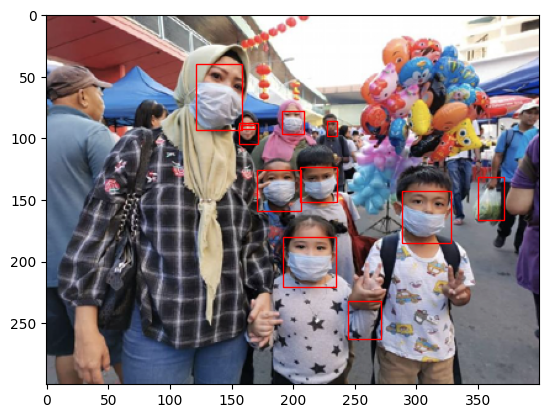

Исходные данные


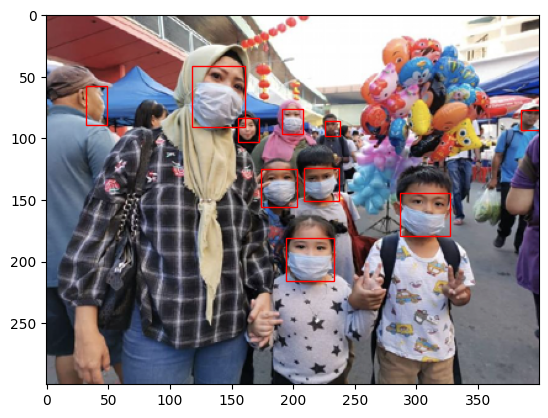

In [16]:
print("Предсказание модели")
plot_predict_image(imgs[2].cpu(), preds[2])
print("Исходные данные")
plot_image(imgs[2].cpu(), annotations[2])

In [17]:
# Сохраним модель
torch.save(model.state_dict(),'model_ADAM_SGD_wn.pt')

### Accuracy

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model_instance_segmentation(4)
model.load_state_dict(torch.load('model_ADAM_SGD_wn.pt'))
model.eval()
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [11]:
dataset = MaskDataset(os.path.join('data/val', 'images'), os.path.join('data/val', 'labels'), data_transform)
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, collate_fn=collate_fn)

In [10]:
len(data_loader)

43

In [12]:
def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, annotations in data_loader:
            imgs = list(img.to(device) for img in imgs)
            outputs = model(imgs)
            for output, annotation in zip(outputs, annotations):
                pred_labels = output['labels'].cpu().numpy()
                true_labels = annotation['labels'].cpu().numpy()
                accuracy = calculate_accuracy(pred_labels, true_labels)
                total += len(true_labels)
                correct += accuracy
            torch.cuda.empty_cache()
    return correct / total

def calculate_accuracy(pred_labels, true_labels):
    correct = 0
    for pred_label, true_label in zip(pred_labels, true_labels):
        if pred_label == true_label:
            correct += 1
    return correct

In [13]:
# Вычислим accuracy
accuracy = evaluate_model(model, data_loader, device)
print(f'Accuracy: {accuracy}')

Accuracy: 0.717815344603381
